In [1]:
!pip install binclass-tools
!pip install plotnine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Importar librerías básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import bctools as bc
import plotnine
from plotnine import *
# Importar módulos de sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [3]:
# Especificar columnas
relevant_columns = ['Tienda','FORMATO','REGION','Categoria','Proveedor','DEPTO','SDEPTO','CLASE','SCLASE','Mes','DiaSem','Sem','Decil','Importado','MarcaPropia','EnOferta','Existencia','Desplazamiento','Y_Faltante']
numerical_columns = ['Decil','Existencia','Desplazamiento','EnOferta']
categorical_columns = ['Tienda','FORMATO','REGION','Categoria','Proveedor','DEPTO','SDEPTO','CLASE','SCLASE','Mes','DiaSem','Sem','Importado','MarcaPropia']
target_column = ['Y_Faltante']
data_columns = ['Decil','Existencia','Desplazamiento','Y_Faltante']

In [4]:
# Abrir el archivo
file = '/content/drive/MyDrive/Experimentos Balance/Datos_faltante_sin_historico.csv'
data = pd.read_csv(file, header=0, usecols=data_columns)
print('rows:', data.shape[0], ' columns:', data.shape[1])

rows: 3889  columns: 4


In [5]:
X = data.drop(columns=['Y_Faltante'])
y = data.Y_Faltante

In [6]:
# Se construyen los conjuntos de entrenamiento y prueba sobre los que se aplicarán algoritmos de machine learning
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, test_size=0.2, random_state=0)
print('Entrenamiento:', X1_train.shape[0], ' Prueba:', X1_test.shape[0])

Entrenamiento: 3111  Prueba: 778


In [8]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=0)
model.fit(X1_train, y1_train)
model.predict(X1_test)
acc_train = model.score(X1_train,y1_train)
acc_test = model.score(X1_test,y1_test)

print(f'Precisión entrenamiento: {acc_train.round(4)}, Presición validación: {acc_test.round(4)}')

Precisión entrenamiento: 0.9958, Presición validación: 0.8252


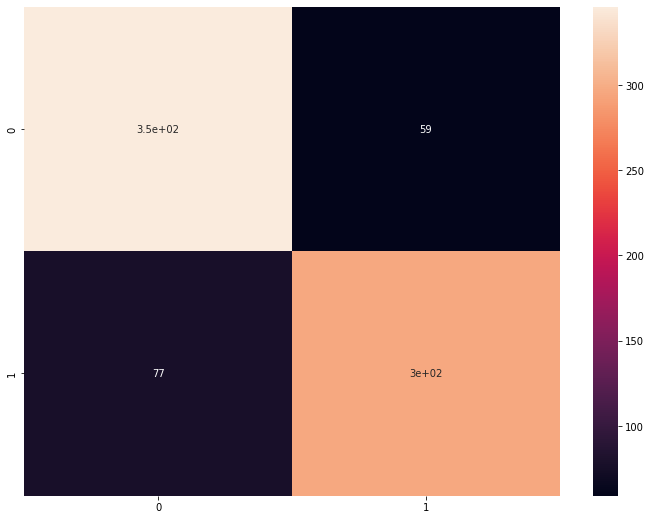

In [9]:
from sklearn.metrics import confusion_matrix
#y_test = label_test
y_pred = model.predict(X1_test)
mat = confusion_matrix(y1_test, y_pred)
plt.figure(figsize=(12, 9))
sns.heatmap(mat, annot=True)
plt.show()

In [10]:
accuracy = accuracy_score(y1_test,y_pred)
recall = recall_score(y1_test,y_pred)
precision = precision_score(y1_test,y_pred)
balanced_accuracy = balanced_accuracy_score(y1_test,y_pred)
f1 = f1_score(y1_test,y_pred)
print(f'Accuracy: {accuracy}')
print(f'True Positive Rate {recall}')
print(f'Precision {precision}')
print(f'Balanced accuracy {balanced_accuracy}')
print(f'f1 score {f1}')

Accuracy: 0.8251928020565553
True Positive Rate 0.7935656836461126
Precision 0.8338028169014085
Balanced accuracy 0.8239433356502168
f1 score 0.8131868131868133


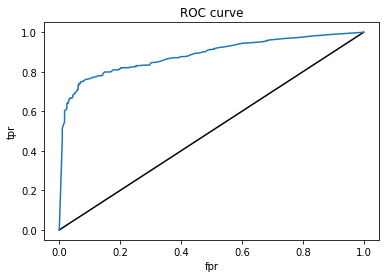

In [11]:
# Dibujamos la curva de ROC para este modelo
from sklearn.metrics import roc_curve
y_pred_proba = model.predict_proba(X1_test)[:,1]
fpr, tpr, thresholds = roc_curve(y1_test, y_pred_proba,pos_label=1)
plt.plot([0,1],[0,1],'k-')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

In [12]:
# Get prediction probabilities for the train set
train_predicted_proba = model.predict_proba(X1_train)[:,1]

# Get prediction probabilities for the test set
test_predicted_proba = model.predict_proba(X1_test)[:,1] 

In [59]:
# Calculamos las entradas de la matriz de confusión
tn, fp, fn, tp = confusion_matrix(y1_test, y_pred).ravel()
tn,fp,fn,tp

(346, 59, 77, 296)

In [13]:
area_under_ROC = bc.curve_ROC_plot(true_y= y1_test, 
                                   predicted_proba = test_predicted_proba)

Length of sequence: 10000
Best Threshold: 0.59 with F-Score: 0.8208


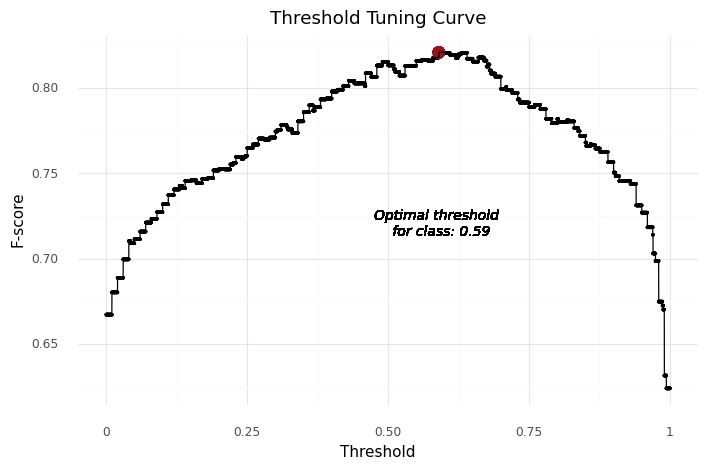

<ggplot: (8727778551709)>

In [14]:
# Array for finding the optimal threshold
thresholds = np.arange(0.0, 1.0, 0.0001)
fscore = np.zeros(shape=(len(thresholds)))
print('Length of sequence: {}'.format(len(thresholds)))

# Fit the model
for index, elem in enumerate(thresholds):
    # Corrected probabilities
    y_pred_prob = (y_pred_proba > elem).astype('int')
    # Calculate the f-score
    fscore[index] = f1_score(y1_test, y_pred_prob)

# Find the optimal threshold
index = np.argmax(fscore)
thresholdOpt = round(thresholds[index], ndigits = 4)
fscoreOpt = round(fscore[index], ndigits = 4)
print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))

# Plot the threshold tuning
df_threshold_tuning = pd.DataFrame({'F-score':fscore,
                                    'Threshold':thresholds})
df_threshold_tuning.head()

plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_threshold_tuning)+
    geom_point(aes(x = 'Threshold',
                   y = 'F-score'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = thresholdOpt,
                   y = fscoreOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'Threshold',
                   y = 'F-score'))+
    # Annotate the text
    geom_text(aes(x = thresholdOpt,
                  y = fscoreOpt),
              label = 'Optimal threshold \n for class: {}'.format(thresholdOpt),
              nudge_x = 0,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'Threshold Tuning Curve')+
    xlab('Threshold')+
    ylab('F-score')+
    theme_minimal()
)

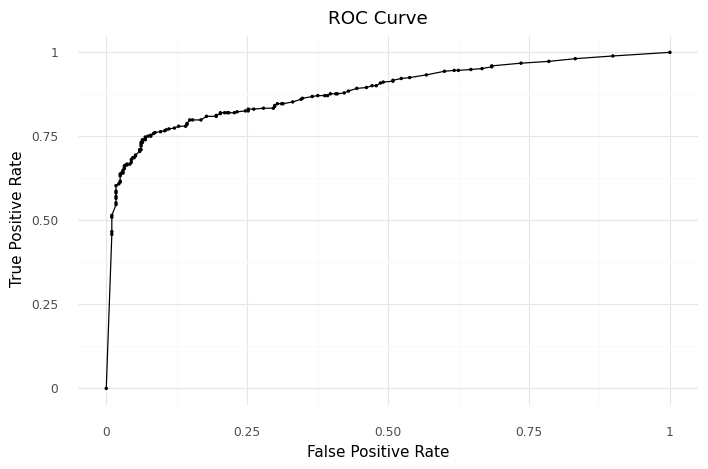

<ggplot: (8727773307605)>

In [15]:
# Create the ROC curve
y_pred_proba = model.predict_proba(X1_test)[:,1]
fpr, tpr, thresholds = roc_curve(y1_test, y_pred_proba)

# Plot the ROC curve
df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})
df_fpr_tpr.head()

# Create the data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate')+
    ylab('True Positive Rate')+
    theme_minimal()
)

Best Threshold: 0.64 with G-Mean: 0.8344
FPR: 0.0691, TPR: 0.748


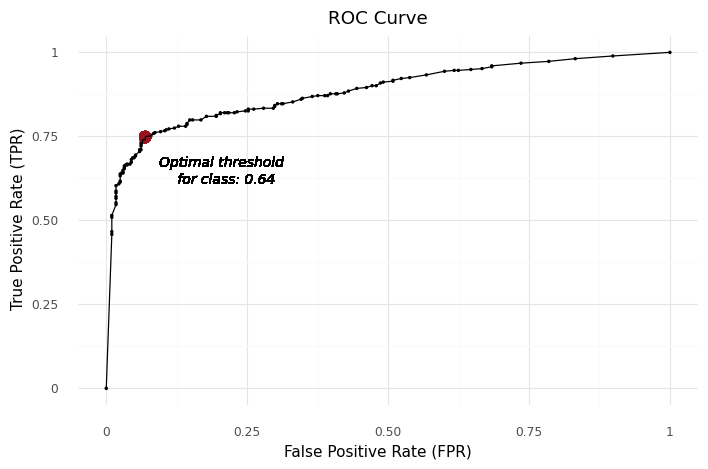

<ggplot: (8727772892881)>

In [16]:
# Calculate the G-mean
gmean = np.sqrt(tpr * (1 - fpr))

# Find the optimal threshold
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

# Create data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = fprOpt,
                   y = tprOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    geom_text(aes(x = fprOpt,
                  y = tprOpt),
              label = 'Optimal threshold \n for class: {}'.format(thresholdOpt),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_minimal()
)


Best Threshold: 0.64 with Youden J statistic: 0.8344
FPR: 0.0691, TPR: 0.748


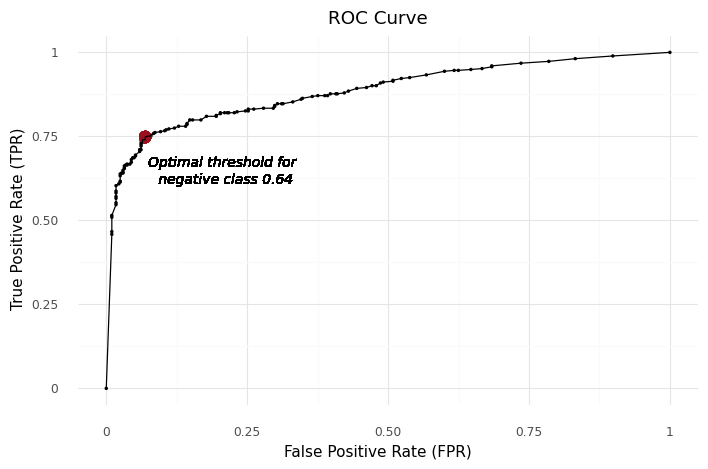

<ggplot: (8727773990421)>

In [17]:
# Calculate the Youden's J statistic
youdenJ = tpr - fpr

# Find the optimal threshold
index = np.argmax(youdenJ)
thresholdOpt = round(thresholds[index], ndigits = 4)
youdenJOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with Youden J statistic: {}'.format(thresholdOpt, youdenJOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

# Create a data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = fprOpt,
                   y = tprOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    # Annotate the text
    geom_text(aes(x = fprOpt,
                  y = tprOpt),
              label = 'Optimal threshold for \n negative class {}'.format(thresholdOpt),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_minimal()
)

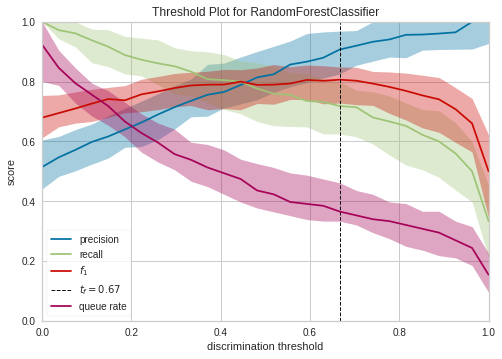

In [18]:
import warnings
from yellowbrick.classifier.threshold import discrimination_threshold

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    discrimination_threshold(model, X1_test, y1_test)

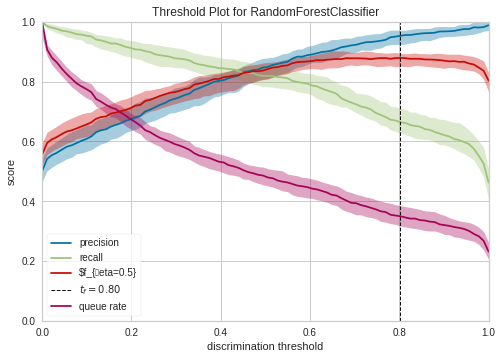

In [19]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    discrimination_threshold(model, X, y, fbeta=0.5)

In [20]:
y = model.predict_proba(X1_test[0:1])[0][1]

In [21]:
y

0.98

In [54]:
def inference(registro):
  check = model.predict_proba(registro[0:1])[0][1]
  if check >= tprOpt: 
    return 1
  else:
    return 0

def construye_arreglo(conjunto_inferencia):
  arreglo = []
  for i in range(len(conjunto_inferencia)):
    x = inference(conjunto_inferencia[i:i+1])
    arreglo.append(x)
  new = np.array(arreglo)
  return new

In [55]:
y_new_pred = construye_arreglo(X1_test)

In [56]:
len(y_new_pred) == len(y1_test)

True

In [57]:
accuracy = accuracy_score(y1_test,y_new_pred)
recall = recall_score(y1_test,y_new_pred,average='binary',pos_label=1)
precision = precision_score(y1_test,y_new_pred,average='binary',pos_label=0)
balanced_accuracy = balanced_accuracy_score(y1_test,y_new_pred)
f1 = f1_score(y1_test,y_new_pred,pos_label=1)
print(f'Accuracy: {accuracy}')
print(f'True Positive Rate {recall}')
print(f'Precision {precision}')
print(f'Balanced accuracy {balanced_accuracy}')
print(f'f1 score {f1}')

Accuracy: 0.8251928020565553
True Positive Rate 0.6916890080428955
Precision 0.7695390781563126
Balanced accuracy 0.8199185780955218
f1 score 0.7914110429447851


In [58]:
# Calculamos las entradas de la matriz de confusión
tn, fp, fn, tp = confusion_matrix(y1_test, y_new_pred).ravel()
tn,fp,fn,tp

(384, 21, 115, 258)